## Import Equations of Motion

In [5]:
import sympy as sym
import numpy as np
sym.init_printing()

from ae353_quadrotor import get_gravity
planet = "Earth"
grav = get_gravity(planet, verbose=True)

# Mass and moment of inertia of the bus
mass = 0.5    # The mass of the quadrotor in kg
Ixx = 0.0023  # The moment of inertia of the quadrotor in 
Iyy = 0.0023  # The mass of the quadrotor in kg
Izz = 0.0040  # The mass of the quadrotor in kg
lxy = 0.25    # The x or y distance from the quadrotor frame to the mocap markers in meters
lz = 0.046875 # The z distance from the quadrotor frame to the mocap markers in meters

# Define position
px_inW, py_inW, pz_inW = sym.symbols('p_x, p_y, p_z')
p_inW = sym.Matrix([[px_inW],
                    [py_inW],
                    [pz_inW]])

# Define velocity
vx_inB, vy_inB, vz_inB = sym.symbols('v_x, v_y, v_z')
v_inB = sym.Matrix([[vx_inB],
                    [vy_inB],
                    [vz_inB]])

# Define roll (phi), pitch (theta), and yaw (psi) angles
phi, theta, psi = sym.symbols('phi, theta, psi')

# Define angular velocities
wx_inB, wy_inB, wz_inB = sym.symbols('omega_x, omega_y, omega_z')
w_inB = sym.Matrix([[wx_inB],
                    [wy_inB],
                    [wz_inB]])

# Define roll, pitch, and yaw rotation matrices that describe the bus's orientation in the 
# world frame
Rx = sym.Matrix([[1,            0,             0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi),  sym.cos(phi)]])
Ry = sym.Matrix([[ sym.cos(theta), 0, sym.sin(theta)],
                 [              0, 1,              0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi),  sym.cos(psi), 0],
                 [           0,             0, 1]])
R_ofB_inW = Rz @ Ry @ Rx
R_ofW_inB = R_ofB_inW.T

# Define inputs
taux_inB, tauy_inB, tauz_inB, fz_inB = sym.symbols('tau_x, tau_y, tau_z, f_z')

# Get the net torque vector
tau_inB = sym.Matrix([[taux_inB],
                      [tauy_inB],
                      [tauz_inB]])
tau_inB = sym.simplify(tau_inB)

# Get the gravity force and convert to body coordiantes
grav_inW = sym.Matrix([[0.],
                       [0.],
                       [-mass * grav]])
grav_inB = R_ofW_inB @ grav_inW

# Get the net force vector
f_inB = grav_inB + sym.Matrix([[0.],
                               [0.],
                               [fz_inB]])
f_inB = sym.simplify(f_inB)

# Assemble the moment of inertia matrix
I_inB = sym.Matrix([[Ixx, 0.,  0.],
                    [0.,  Iyy, 0.],
                    [0.,  0.,  Izz]])

v_inW = R_ofB_inW @ v_inB
xyz_dot = sym.simplify(v_inW)
print("px, py, pz rate as a function of orientation and body-fixed velocities:")
sym.N(xyz_dot,3)

v_inB_dot = (1 / mass) * (f_inB - w_inB.cross(mass * v_inB))
v_inB_dot = sym.simplify(v_inB_dot)
print("Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces:")
sym.N(v_inB_dot,3)

# Define the transformation that takes roll, pitch, and yaw rates to body-fixed angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

# Invert the transformation to get a matrix that takes body-fixed angular rates to 
# roll, pitch, and yaw rates
M_inv = sym.simplify(M.inv())

# Convert the body-fixed angular rates to roll, pitch, and yaw rates
rpy_dot = sym.simplify(M_inv@w_inB)
print("Roll, pitch, and yaw rate as a function of orientation and body-fixed angular rates:")
sym.N(rpy_dot,3)

# Apply Euler's equation to get the time derivative of the angular velocities of the
# quadrotor in the quadrotor frame
w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
w_inB_dot = sym.simplify(w_inB_dot)
print("Time derivative of the angular velocities in the body-fixed frame:")
sym.N(w_inB_dot, 3)

f = sym.Matrix.vstack(xyz_dot,
                      v_inB_dot,
                      rpy_dot,
                      w_inB_dot)

# Position of markers in body frame
mark1_inB = sym.Matrix([[lxy],
                        [0.],
                        [lz]])
mark2_inB = sym.Matrix([[0.],
                        [lxy],
                        [lz]])
mark3_inB = sym.Matrix([[-lxy],
                        [0.],
                        [lz]])
mark4_inB = sym.Matrix([[0.],
                        [-lxy],
                        [lz]])

# Position of markers in world frame
mark1_inW = p_inW + R_ofB_inW @ mark1_inB
mark2_inW = p_inW + R_ofB_inW @ mark2_inB
mark3_inW = p_inW + R_ofB_inW @ mark3_inB
mark4_inW = p_inW + R_ofB_inW @ mark4_inB

# Sensor model
g = sym.simplify(sym.Matrix.vstack(mark1_inW, mark2_inW, mark3_inW, mark4_inW))


px, py, pz rate as a function of orientation and body-fixed velocities:
Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces:
Roll, pitch, and yaw rate as a function of orientation and body-fixed angular rates:
Time derivative of the angular velocities in the body-fixed frame:


## System Linearization and State Space Form

### Equilbrium

In [6]:
# Define nonlinear state and input vectors for linearization
m = sym.Matrix([px_inW, py_inW, pz_inW,
                vx_inB, vy_inB, vz_inB,
                phi, theta, psi,
                wx_inB, wy_inB, wz_inB])

n = sym.Matrix([taux_inB, tauy_inB, tauz_inB, fz_inB])

# Define equilibrium point (hover):
p_x_e = 0.
p_y_e = 0.
p_z_e = 0.
v_x_e = 0.
v_y_e = 0.
v_z_e = 0.
phi_e = 0.
theta_e = 0.
psi_e = 0.
w_x_e = 0.
w_y_e = 0.
w_z_e = 0.
tau_x_e = 0.
tau_y_e = 0.
tau_z_e = 0.
f_z_e = mass * grav

equilibrium = {px_inW: p_x_e,
               py_inW: p_y_e,
               pz_inW: p_z_e,
               vx_inB: v_x_e,
               vy_inB: v_y_e,
               vz_inB: v_z_e,
               phi: phi_e,
               theta: theta_e,
               psi: psi_e,
               wx_inB: w_x_e,
               wy_inB: w_y_e,
               wz_inB: w_z_e,
               taux_inB: tau_x_e,
               tauy_inB: tau_y_e,
               tauz_inB: tau_z_e,
               fz_inB: f_z_e}

# Nonlinear state m at equilbrium
m_num = sym.lambdify([px_inW, py_inW, pz_inW,
                vx_inB, vy_inB, vz_inB,
                phi, theta, psi,
                wx_inB, wy_inB, wz_inB],  m)

#Evaluate x at the equilibrium point
m_e = m_num(p_x_e, p_y_e, p_z_e, v_x_e, v_y_e, v_z_e, phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e)

# Input at equilbirum
n_num = sym.lambdify([taux_inB, tauy_inB, tauz_inB, fz_inB], n)

#Evaluate u at the equilibrium point
n_e = n_num(tau_x_e, tau_y_e, tau_z_e, f_z_e)

# Create a lambda function for o that includes all variables
o_num = sym.lambdify([px_inW, py_inW, pz_inW,
                vx_inB, vy_inB, vz_inB,
                phi, theta, psi,
                wx_inB, wy_inB, wz_inB], g)

# Evaluate o at the equilibrium point
o_e = o_num(p_x_e, p_y_e, p_z_e, v_x_e, v_y_e, v_z_e, phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e)

display(sym.Matrix(o_e))

⎡  0.25  ⎤
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢0.046875⎥
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢  0.25  ⎥
⎢        ⎥
⎢0.046875⎥
⎢        ⎥
⎢ -0.25  ⎥
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢0.046875⎥
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢ -0.25  ⎥
⎢        ⎥
⎣0.046875⎦

### Linearize the EoM

In [7]:
# Linearize the equations of motion
A = f.jacobian(m)
B = f.jacobian(n)

A_e = A.subs(equilibrium)
B_e = B.subs(equilibrium)

C = g.jacobian(m)
C_e = C.subs(equilibrium)

D = g.jacobian(n)
D_e = D.subs(equilibrium)

print("Linearized A matrix at equilibrium:")
sym.pprint(A_e)
print("\nLinearized B matrix at equilibrium:")
sym.pprint(B_e)
print("Linearized C matrix at equilibrium:")
sym.pprint(C_e)
print("Linearized D matrix at equilibrium:")
sym.pprint(D_e)

Linearized A matrix at equilibrium:
⎡0  0  0  1  0  0    0     0    0  0  0  0⎤
⎢                                         ⎥
⎢0  0  0  0  1  0    0     0    0  0  0  0⎥
⎢                                         ⎥
⎢0  0  0  0  0  1    0     0    0  0  0  0⎥
⎢                                         ⎥
⎢0  0  0  0  0  0    0    9.81  0  0  0  0⎥
⎢                                         ⎥
⎢0  0  0  0  0  0  -9.81   0    0  0  0  0⎥
⎢                                         ⎥
⎢0  0  0  0  0  0    0     0    0  0  0  0⎥
⎢                                         ⎥
⎢0  0  0  0  0  0    0     0    0  1  0  0⎥
⎢                                         ⎥
⎢0  0  0  0  0  0    0     0    0  0  1  0⎥
⎢                                         ⎥
⎢0  0  0  0  0  0    0     0    0  0  0  1⎥
⎢                                         ⎥
⎢0  0  0  0  0  0    0     0    0  0  0  0⎥
⎢                                         ⎥
⎢0  0  0  0  0  0    0     0    0  0  0  0⎥
⎢                                       

### Verify Controllability and Observability

In [8]:
# Convert A and B to numeric arrays for controllability/observability checks
A_num = np.array(A_e, dtype=float)
B_num = np.array(B_e, dtype=float)
C_num = np.array(C_e, dtype=float)

l = A_num.shape[0]
j = B_num.shape[1]

# Controllability Check
controllability_matrix = B_num
for i in range(1, l):
    controllability_matrix = np.hstack((controllability_matrix, np.linalg.matrix_power(A_num, i) @ B_num))

rank_C = np.linalg.matrix_rank(controllability_matrix)
print(f"\nControllability matrix rank: {rank_C} out of {l}")
if rank_C == l:
    print("System is controllable.")
else:
    print("System is not fully controllable.")

# Observability Check
observability_matrix = C_num
for i in range(1, l):
    observability_matrix = np.vstack((observability_matrix, C_num @ np.linalg.matrix_power(A_num, i)))

rank_O = np.linalg.matrix_rank(observability_matrix)
print(f"\nObservability matrix rank: {rank_O} out of {l}")
if rank_O == l:
    print("System is observable.")
else:
    print("System is not fully observable with chosen C.")


Controllability matrix rank: 12 out of 12
System is controllable.

Observability matrix rank: 12 out of 12
System is observable.


## Gain Selection

### Controller

In [43]:
# Design gain matrices for the controller
import scipy as scipy

Q = np.diag([1/75**2, 1/75**2, 1/7**2, 1/75**2, 1/75**2, 1/70**2, 1/25**2, 1/75**2, 1/75**2, 1/25**2, 1/25**2, 1/25**2])  # State cost
R = np.diag([1/0.265**2, 1/0.265**2, 1/0.7**2, 1/12.9**2])

P = scipy.linalg.solve_continuous_are(A_num, B_num, Q, R)
K = np.linalg.inv(R) @ (B_num.T @ P)

print("\nLQR Gain Matrix K:")
print(K)


LQR Gain Matrix K:
[[-7.19728584e-18 -3.53333333e-03 -3.42583700e-17 -4.98629433e-18
  -6.94909974e-03 -8.73664465e-17  4.97055246e-02 -2.81140462e-17
   4.72105208e-18  1.84663319e-02 -4.24684114e-18  1.28708712e-18]
 [ 3.53333333e-03 -7.77578074e-19  3.11351051e-17  6.86515256e-03
   3.42883671e-20  3.88829645e-18 -4.25878261e-18  4.80956654e-02
   2.15669701e-18 -4.24684114e-18  1.82647218e-02 -3.87467709e-18]
 [ 5.19773536e-18 -2.75943746e-18  1.81801639e-17 -1.40583782e-17
  -5.12469073e-18  3.86235148e-17  2.63205911e-17 -5.90782333e-17
   9.33333333e-03  5.16392733e-18 -1.55456073e-17  2.93030146e-02]
 [-3.12933628e-18  1.01722770e-15  1.84285714e+00 -3.81227683e-18
   1.04650990e-15  1.36997021e+00 -6.16588582e-15  9.30603795e-17
   1.26036459e-16 -9.52335944e-16  4.23842862e-17  1.04936149e-16]]


In [44]:
# Find the eigenvalues of F for stability check
F = A_num - B_num@K

#Determine if all eigenvalues of F have negative real part
if(np.all(np.linalg.eigvals(F).real < 0)):
    print("The controller is asymptotically stable")
else:
    print("The controller is not asymptotically stable")

The controller is asymptotically stable


### Observer

In [45]:
# Observer Q and R matrices
Q_o = np.diag([1] * A_num.shape[0])
R_o = np.diag([1] * C_num.shape[0])

P_o = scipy.linalg.solve_continuous_are(A_num.T, C_num.T, np.linalg.inv(R_o), np.linalg.inv(Q_o))

#Solve for L
L =  (Q_o @ C_num @ P_o.T).T

#Define H
H = A_num - L@C_num

print("\nLQR Gain Matrix L:")
print(L)


LQR Gain Matrix L:
[[ 1.60290621e+00  7.38172449e-16 -1.90234589e-01  1.60290621e+00
   7.27064974e-16  7.36220606e-17  1.60290621e+00  7.15957499e-16
   1.90234589e-01  1.60290621e+00  7.27064974e-16 -2.10273108e-16]
 [ 7.77600554e-16  1.60290621e+00  3.46414193e-16  9.37033207e-16
   1.60290621e+00 -1.90234589e-01  7.77600554e-16  1.60290621e+00
   6.01565209e-16  6.18167900e-16  1.60290621e+00  1.90234589e-01]
 [-6.56794035e-17  3.66756943e-16  7.07106781e-01  6.02093699e-17
   4.92645716e-16  7.07106781e-01 -6.56794035e-17  6.18534490e-16
   7.07106781e-01 -1.91568177e-16  4.92645716e-16  7.07106781e-01]
 [ 4.91038697e+00  4.58567953e-15 -1.25643282e+00  4.91038697e+00
   4.54390050e-15 -1.48588734e-16  4.91038697e+00  4.50212147e-15
   1.25643282e+00  4.91038697e+00  4.54390050e-15  7.65875736e-17]
 [-1.57289721e-15  4.91038697e+00  3.17556932e-16 -2.31902266e-16
   4.91038697e+00 -1.25643282e+00 -1.57289721e-15  4.91038697e+00
   1.76841003e-15 -2.91389216e-15  4.91038697e+00  1

In [46]:
if(np.all(np.linalg.eigvals(H).real < 0)):
    print("The observer is asymptotically stable")
else:
    print("The system is not asymptotically stable")

The observer is asymptotically stable


In [78]:
# Create the Controller class
class Controller():
    def __init__(self):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
        """
        self.A = A_num 
        self.B = B_num   
        self.C = C_num   
        self.K = K
        self.L = L

        self.m_e = np.array([p_x_e, p_y_e, p_z_e, v_x_e, v_y_e, v_z_e, phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e])
        self.n_e = np.array([tau_x_e, tau_y_e, tau_z_e, f_z_e])
        self.o_e = o_e
        self.p_x_e = p_x_e
        self.p_y_e = p_y_e
        self.p_z_e = p_z_e
        self.v_x_e = v_x_e
        self.v_y_e = v_y_e
        self.v_z_e = v_z_e
        self.phi_e = phi_e
        self.theta_e = theta_e
        self.psi_e = psi_e
        self.omega_x_e = w_x_e
        self.omega_y_e = w_y_e
        self.omega_z_e = w_z_e
        self.tau_x_e = tau_x_e
        self.tau_y_e = tau_y_e
        self.tau_z_e = tau_z_e
        self.f_z_e = f_z_e
        self.e_max = 0.4
        self.x_hat_vals = {"p_x" : [],
                     "p_y" : [],
                     "p_z" : []}
        self.goalhat_history = []


        pass

    
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
        """
        self.xhat = np.zeros((12, 1))  # Initialize state estimate as zero
        self.x_des = np.zeros((12, 1)) # Initialize desired state as zero
        self.xhat_values = {"px" : [], "py" : [], "pz" : [], "vx" : [], "vy" : [], "vz" : [], 
                            "phi" : [], "theta" : [], "psi" : [], "wx" : [], "wy" : [], "wz" : []}
        self.x_hat_vals = {"p_x" : [],
                     "p_y" : [],
                     "p_z" : []}
        self.goalhat_values = {"p_x" : [],
                     "p_y" : [],
                     "p_z" : []}
        self.desired_values = {"p_des_x" : [], "p_des_y" : [], "p_des_z" : []}
        self.goalhat_history = []

        pass
    
    
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        """

        dt = kwargs["dt"]
        self.dt = dt

        # Gate and direction information
        next_gate = np.array(kwargs["next_gate"]).reshape(-1, 1)
        dir_gate = np.array(kwargs["dir_gate"]).reshape(-1, 1)
        self.goal = next_gate
        self.goal_direction = dir_gate
        self.goal_hat = self.xhat[:3]

        # Parameters for gradient descent-based navigation
        k_des = 1.0
        r_drone = 0.5

        # Calculate distance to the next gate
        distance_to_gate = np.linalg.norm(self.goal_hat - self.goal)
        if distance_to_gate > 14:
            k_attract = 16.25
        else:
            k_attract = 11.5

        """
        18.4 s
        distance_to_gate = np.linalg.norm(self.goal_hat - self.goal)
        if distance_to_gate > 13:
            k_attract = 16.5
        else:
            k_attract = 11.5
        """
        # Attractive term
        h_attract = k_attract * (self.goal_hat - self.goal) / np.linalg.norm(self.goal_hat - self.goal)

        # Total gradient
        h = h_attract

        # Desired position update via gradient descent
        if np.linalg.norm(self.goal - self.goal_hat) < self.e_max:
            self.p_des = self.goal
        else:
            self.p_des = self.goal_hat - k_des * h
        self.p_des = self.p_des.reshape(-1, 1)

        # Construct the desired state (x_des)
        zero_vector = np.zeros((9, 1))
        self.x_des = np.vstack((self.p_des, zero_vector))

        # Compute control inputs
        u_des = np.array([self.tau_x_e, self.tau_y_e, self.tau_z_e, self.f_z_e])
        u = -self.K @ (self.xhat - self.x_des)
        inputs = u + u_des.reshape(-1, 1)

        # Measurement update
        o = np.block([kwargs["mocap_1"], kwargs["mocap_2"], kwargs["mocap_3"], kwargs["mocap_4"]]).reshape(-1, 1)
        y = o - self.o_e

        # State estimation update
        self.xhat += dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)).astype(float)

        # Extract final control inputs
        torque_x = inputs[0, 0]
        torque_y = inputs[1, 0]
        torque_z = inputs[2, 0]
        force_z = inputs[3, 0]

        # Store historical data
        self.x_hat_vals["p_x"].append(self.xhat[0, 0])
        self.x_hat_vals["p_y"].append(self.xhat[1, 0])
        self.x_hat_vals["p_z"].append(self.xhat[2, 0])
        self.desired_values["p_des_x"].append(self.p_des[0, 0])
        self.desired_values["p_des_y"].append(self.p_des[1, 0])
        self.desired_values["p_des_z"].append(self.p_des[2, 0])

        self.goalhat_history.append(self.x_des)

        return torque_x, torque_y, torque_z, force_z

In [79]:
# Create an instance of our Controller class to simulate 1 quadrotor
controller1 = Controller()

## Running the Simulation

Before we run the simulation, we must first import the simulation module and then create an instance of the simulator. This is done below:

In [80]:
# Import the quadrotor project. This module is used to simulate, render, and plot a quadrotor dynamic system
import ae353_quadrotor

In [81]:
# Make an instance of the simulator for 1 quadrotor
team_list = [""]
sim = ae353_quadrotor.Quadrotor_Sim(n_quadrotors=1,
                                    team_list=team_list,
                                    planet="Earth",
                                    use_keyboard=True,
                                    visualization=True,
                                    visualization_fr=45.,
                                    animation=False,
                                    verbose=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/


In [82]:
# Run the simulation and collect the simulation data\
controllers = [controller1]
(track_stats, data) = sim.run(controllers,
                              sensor_noise=0.01,
                              collect_data=True,
                              max_time=60.0,
                              verbose=True)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
:0 PASSED GATE 1 IN 2.89s
:0 PASSED GATE 2 IN 5.11s
:0 PASSED GATE 3 IN 7.15s
:0 PASSED GATE 4 IN 10.53s
:0 PASSED GATE 5 IN 13.15s
:0 PASSED GATE 6 IN 17.92s
:0 PASSED GATE 7 IN 19.86s
:0 COMPLETED LAP IN 19.86s


In [83]:
# Print out the track stats for each quadrotor
for i in range(len(track_stats)):
    stat = track_stats[i]
    print("Quadrotor {} completed lap: {}".format(i, stat["completed_lap"]))
    if len(stat["gate_times"]) > 0:
        print("Gate times for Quadrotor {}: {}".format(i, stat["gate_times"]))
    else:
        print("Quadrotor {} passed no gates.".format(i))
    if stat["completed_lap"]:
        print("Lap time for Quadrotor {}: {}".format(i, stat["lap_time"]))
    print("\n")

Quadrotor 0 completed lap: True
Gate times for Quadrotor 0: [2.89, 5.11, 7.15, 10.53, 13.15, 17.92, 19.86]
Lap time for Quadrotor 0: 19.86




## FIXME: Post-processing the simulation data

After the simulation is run, we can plot the data using the Matplotlib package. To start, we import matplotlib and numpy.

In [84]:
# Import the pyplot module from the matplotlib package
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

Now we can make whichever plots we see fit to make sense of the simulation data. Here we plot the ground track and altitude.

**THIS IS LEFT INTENTIONALLY AS INSUFFICIENT TO PROVE YOUR CONTROLLER OR OBSERVER WORK.**

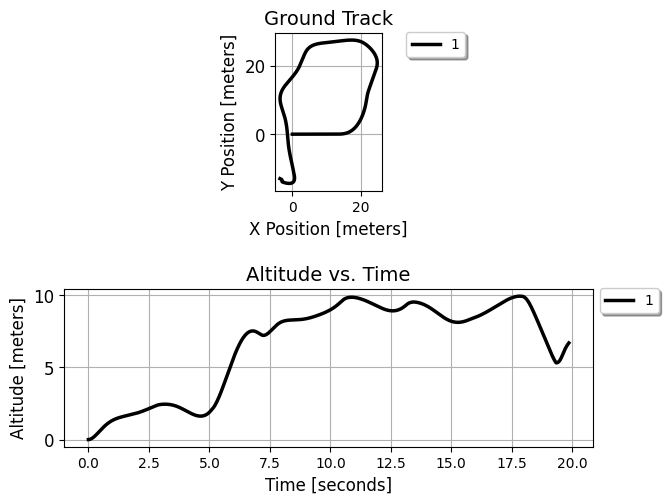

In [85]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=False)

# Convert the position data to array
colors = ['k','r','g','b','m','c','tab:orange','tab:purple','tab:brown','tab:pink','tab:gray']
for i in range(len(data)):
    
    # Get the position
    pos = np.array(data[i]['position'])
    
    # Create a plot of the ground path of the quadrotor
    axes[0].plot(pos[:,0], pos[:,1], c=colors[i], lw=2.5, label=str(i+1))
    
    # Create a plot of the altitude versus time
    axes[1].plot(data[0]['time'], pos[:,2], c=colors[i], lw=2.5, label=str(i+1))

# Make plot 0 pretty
axes[0].set_xlabel("X Position [meters]", fontsize=12)
axes[0].set_ylabel("Y Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].legend(bbox_to_anchor=(1.16, 1.05), fancybox=True, shadow=True)
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("Altitude [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].legend(bbox_to_anchor=(1., 1.05), fancybox=True, shadow=True)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()